# Data Reduction and Photometry:

This lab begins the process of reducing the observing project and using photometry techniques to analyze it. 

### 1: Bias and Overscan

__Define the bias. Include both a description of what it looks like physically, why it
occurs, and how we take it into account (how do we remove its effect on our data
images?) Your data is from the ARCTIC instrument - it has two modes (one amplifier read
out or four amplifier read out).__

The bias is the readout of the ccd when it hasn't been exposed to any light. The results of this readout shows that the amplifier has been set to some offset voltage inorder to avoid negative numbers while taking an actual image. What it looks like physically is the entire ccd exposed to light that is very uniform. The noise in a bias scan comes from the electrinics alone. This can be seen below. To take the bias into account

In [87]:
from astropy.nddata import CCDData
from astropy.visualization import hist
from pathlib import Path

import astropy.io.fits as fits
import glob
import ccdproc as ccdp
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd


In [88]:
def imagePreview(path, vMin = 5, vMax = 99.7):
    """
    Function that creates plots of all data from fits files at the end of the path passed
    Useful for visual inspection of the data
    """
    fileNames = glob.glob(path)
    openFits = [ fits.open(a) for a in fileNames]

    data = [a[0].data for a in openFits]
    fig, ax = plt.subplots(len(fileNames), 1, figsize= (8,8*len(fileNames)) )

    for i in range(len(fileNames)):
        ax[i].imshow(data[i], vmin=np.percentile(data[i], vMin), vmax=np.percentile(data[i], vMax),
                   origin='lower', cmap='binary_r', interpolation='nearest')

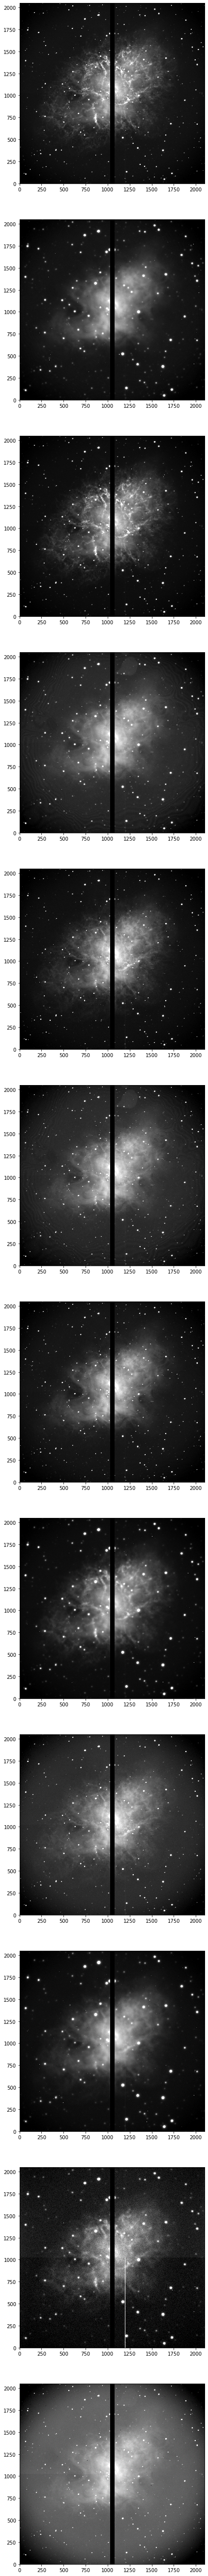

In [89]:
imagePreview('data/CrabNebula*.fits')

__Why would we use more than one bias frame__

The purpose of combining many bias' is to reduce the read noise in the combined bias.

The first step will be to fix the headers so that they can actually be read in.

In [90]:
fileNames = glob.glob('data/bias*.fits')
imageData = [fits.open(a) for a in fileNames]

headers = [a[0].header for a in imageData]
for a in headers:
    del a['CD1_1']
    del a['CD1_2']
    del a['CD2_1']
    del a['CD2_2']

In [91]:
for a in range(len(fileNames)):
    image = imageData[a]
    fits.writeto('data/trimmed_bias/fixedBias.000{0}.fits'.format(a), image[0].data, headers[a], overwrite = True)

Ok now it will be good to look at the headers. Below I define a function to get the headers and create a pandas dataframe since it's a little easier to look at specific columns using those. I also couldve used the ccdproc built in class `ImageFileCollection`

In [92]:
def getHeaders(path):
    """
    take the headers and make them into a dataframe so
    that they can be easily examined
    """
    fileNames = glob.glob(path)
    keys = list(imageData[0][0].header.keys())
    dic = {}
    for i in keys:
        dic.update( {i : [a[0].header[i] for a in imageData]} )
    imageInfo = pd.DataFrame(data = dic)
    return imageInfo

In [93]:
biasHeaders = getHeaders('data/fixedBias*.fits')
biasHeaders[['FILENAME', 'AMPLIST','BSEC11', 'GTGAIN11', 'GTRON11', 'BSEC12',
       'GTGAIN12', 'GTRON12', 'BSEC21', 'GTGAIN21',
       'GTRON21', 'BSEC22', 'GTGAIN22', 'GTRON22']]

,FILENAME,AMPLIST,BSEC11,GTGAIN11,GTRON11,BSEC12,GTGAIN12,GTRON12,BSEC21,GTGAIN21,GTRON21,BSEC22,GTGAIN22,GTRON22
0,bias.0003.fits,11 12 21 22,"[1029:1051,1:1024]",1.97,3.9,"[1029:1051,1027:2050]",1.95,3.9,"[1052:1074,1:1024]",1.95,3.9,"[1052:1074,1027:2050]",1.97,3.8
1,bias.0006.fits,11 12 21 22,"[1029:1051,1:1024]",1.97,3.9,"[1029:1051,1027:2050]",1.95,3.9,"[1052:1074,1:1024]",1.95,3.9,"[1052:1074,1027:2050]",1.97,3.8
2,bias.0005.fits,11 12 21 22,"[1029:1051,1:1024]",1.97,3.9,"[1029:1051,1027:2050]",1.95,3.9,"[1052:1074,1:1024]",1.95,3.9,"[1052:1074,1027:2050]",1.97,3.8
3,bias.0013.fits,11 12 21 22,"[1029:1051,1:1024]",1.97,3.9,"[1029:1051,1027:2050]",1.95,3.9,"[1052:1074,1:1024]",1.95,3.9,"[1052:1074,1027:2050]",1.97,3.8
4,bias.0004.fits,11 12 21 22,"[1029:1051,1:1024]",1.97,3.9,"[1029:1051,1027:2050]",1.95,3.9,"[1052:1074,1:1024]",1.95,3.9,"[1052:1074,1027:2050]",1.97,3.8
5,bias.0001.fits,11 12 21 22,"[1029:1051,1:1024]",1.97,3.9,"[1029:1051,1027:2050]",1.95,3.9,"[1052:1074,1:1024]",1.95,3.9,"[1052:1074,1027:2050]",1.97,3.8
6,bias.0002.fits,11 12 21 22,"[1029:1051,1:1024]",1.97,3.9,"[1029:1051,1027:2050]",1.95,3.9,"[1052:1074,1:1024]",1.95,3.9,"[1052:1074,1027:2050]",1.97,3.8


Ok Cool, now it looks like these images need to have the overscan trimmed off. That is clear from the columns BSECxx above that show where the overscan regions are. Below I copied and pasted code from the book/website to do that. 

In [94]:
calibrated_bias = Path('data/trimmed_bias')
calibrated_bias.mkdir(exist_ok = True)
file = ccdp.ImageFileCollection(calibrated_bias)
bias = [str(file.location) +'/'+ a for a in file.files] # weird way of getting the paths and files together. 
obj = CCDData.read(bias[0], unit = 'adu') #specific object that is required to use ccdproc

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


In [101]:
obj.shape

(2050, 2102)

In [72]:

print(obj.data.shape)
trimmedBiasL =  ccdp.trim_image(obj[:2050, 0:1029])
trimmedBiasR = ccdp.trim_image(obj[:2050, 1074:])
print(trimmedBiasL.data.shape)
trimmedBias = np.append(trimmedBiasL.data, trimmedBiasR.data, axis = 1)
fits.writeto(bias[0], trimmedBias, obj.header, overwrite = True)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


(2050, 2102)
(2050, 1029)
(2050, 1028)


In [110]:
def trimImage(image, reg = [0, 2050, 0, 1029, 0, 2050, 1074, 2102]):
    """
    Function to trim images from the ARCTIC instrument when in quad amplifier mode
    
    keywords:
    image: the CCDData object to be trimmed 
    Region: 
    """
    trimmedL =  ccdp.trim_image(image[reg[0]:reg[1], reg[2]:reg[3]])
    trimmedR = ccdp.trim_image(image[reg[4]:reg[5], reg[6]:reg[7]])
    trimmedBias = np.append(trimmedBiasL.data, trimmedBiasR.data, axis = 1)
    return trimmedBias

In [112]:
region1 = '[:2050, :1029]'
region2 = '[:2050, 1074:]'
regions = [0, 2050, 0, 1029, 0, 2050, 1074]
trimImage(obj)

array([[ 221,  217,  944, ...,  750,  237,  241],
       [ 205,  207,  238, ...,  239,  208,  208],
       [ 212,  210,  249, ...,  248,  213,  208],
       ...,
       [ 217,  217,  251, ...,  255,  222,  219],
       [ 207,  209,  237, ...,  245,  213,  209],
       [ 225,  223,  861, ..., 1060,  236,  237]], dtype=uint16)